In [12]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
import hashlib
import swifter
from scipy import stats

In [13]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password':'dpo_python_2020',
    'user':'student',
    'database':'simulator_20240120',
}

q = '''
select user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where (toDate(time) >= '2023-12-22' and toDate(time) <= '2023-12-28') and (exp_group IN [2, 3])
group by exp_group, user_id
'''

df = ph.read_clickhouse(q, connection=connection)

In [14]:
print(df)

       user_id  exp_group  likes  views       ctr
0       115383          3     38    248  0.153226
1        10326          3     24    132  0.181818
2       123580          3     25    122  0.204918
3       131473          2     19     98  0.193878
4        23985          2     12     44  0.272727
...        ...        ...    ...    ...       ...
16782   122008          3     20    123  0.162602
16783    25383          2      2     18  0.111111
16784   122190          3     15     56  0.267857
16785   108927          2     16     51  0.313725
16786    17310          2     24     75  0.320000

[16787 rows x 5 columns]


## Проверяю равенство записей в группах 2 и 3

In [15]:
#абсолютное количество
df.groupby('exp_group')['user_id'].nunique()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

In [16]:
#в процентах
share_2 = (df[df['exp_group'] == 2]['user_id'].count() / df['user_id'].count()) * 100
share_3 = (df[df['exp_group'] == 3]['user_id'].count() / df['user_id'].count()) * 100

In [17]:
print(share_2)
print(share_3)

49.81235479835587
50.18764520164412


Количество пользователей в двух группах почти одинаковое

## Визуализирую на гистограмме распределения CTR по группам

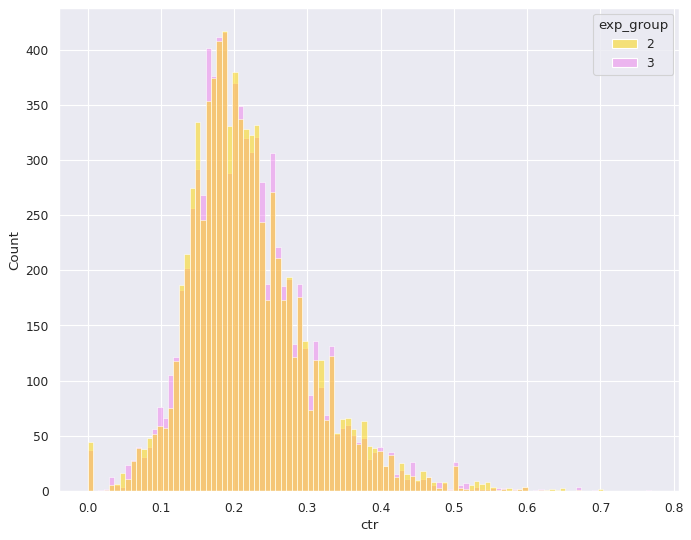

In [19]:
sns.set(rc={'figure.figsize':(10, 8), 'figure.dpi': 80})
g = sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['gold','violet'], alpha = 0.5, kde = False)

!!! По визуализации можно примерно оценить, что распределения более-менее одинаковые

## Разбиваю на два датафрейма

In [21]:
g_2 = df[df['exp_group'] == 2]
g_3 = df[df['exp_group'] == 3]

In [22]:
print(g_2)

       user_id  exp_group  likes  views       ctr
3       131473          2     19     98  0.193878
4        23985          2     12     44  0.272727
5        24523          2      2     10  0.200000
6        24239          2     10     41  0.243902
8       127588          2     14     87  0.160920
...        ...        ...    ...    ...       ...
16780    25071          2      5     15  0.333333
16781    17146          2     23    194  0.118557
16783    25383          2      2     18  0.111111
16785   108927          2     16     51  0.313725
16786    17310          2     24     75  0.320000

[8362 rows x 5 columns]


In [23]:
print(g_3)

       user_id  exp_group  likes  views       ctr
0       115383          3     38    248  0.153226
1        10326          3     24    132  0.181818
2       123580          3     25    122  0.204918
7        19647          3      4     31  0.129032
12      107670          3     17     94  0.180851
...        ...        ...    ...    ...       ...
16774   122758          3     18     85  0.211765
16777    13781          3      6     35  0.171429
16778   130651          3     10     75  0.133333
16782   122008          3     20    123  0.162602
16784   122190          3     15     56  0.267857

[8425 rows x 5 columns]


## Провожу симуляцию 10000 А-А тестов

In [24]:
p_values = []

In [25]:
for _ in range(10000):
    g_2_new = g_2.ctr.sample(500, replace = False)
    g_3_new = g_3.ctr.sample(500, replace = False)
    p_value = stats.ttest_ind(g_2_new, g_3_new, equal_var = False)[1]
    p_values.append(p_value)

In [26]:
p_values = pd.Series(p_values)

In [27]:
print(p_values)

0       0.819829
1       0.154388
2       0.678567
3       0.417723
4       0.640052
          ...   
9995    0.375526
9996    0.010071
9997    0.976632
9998    0.362834
9999    0.445421
Length: 10000, dtype: float64


## Строю гистограмму распределения получившихся 10000 p-values

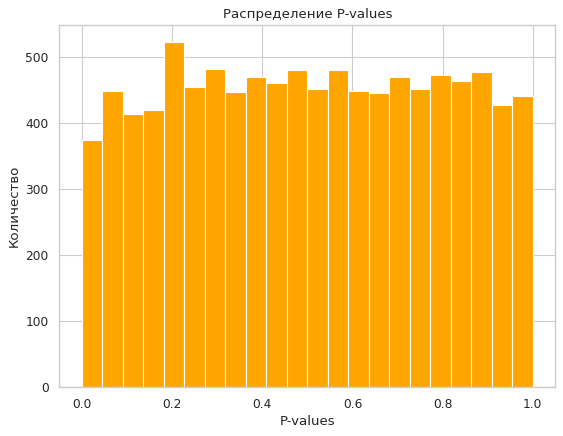

In [41]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
sns.histplot(p_values, ax=ax, color = 'orange', alpha = 1.0)


plt.xlabel('P-values')
plt.ylabel('Количество')
plt.title('Распределение P-values')


plt.show()

!!!Распределение выглядит равномерным

## Считаю процент p-value, который меньше или равен 0.05

In [42]:
cnt = 0
for i in p_values:
    if i <= 0.05:
        cnt += 1
procent = (cnt / len(p_values)) * 100
print(procent)

4.14


!!!В 4.14% случаев p-values оказывается меньше, либо равным 0.05

### Я провел симуляцию 10000 А-А тестов с данными из групп 2 и 3 в периоде с 22.12.23 по 28.12.23. Во время каждой симуляции А-А теста сформировал подвыборки без повторения в 500 пользователей и сравнил их с помощью t-теста, визуализировал распределения CTR по группам и распределение p-values по завершении симуляции, посчитал процент p-value, который меньше или равен 0.05. На основании полученных результов можно сделать вывод, что наша система сплитования работает корректно.